# qBraid Open Challenge

In this open challenge, submissions will be judged on the most creative/compelling use of the [qBraid-SDK](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/sdk/overview.html). The only additional requirement is that you must in some way use [qBraid quantum jobs](https://github.com/qBraid/qbraid-lab-demo/blob/main/qbraid_quantum_jobs.ipynb) to interface with [Amazon Braket supported devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html).

#### Resources

- [qBraid demo notebooks](https://github.com/qBraid/qbraid-lab-demo)
- [qBraid SDK: user guide](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/sdk/overview.html)
- [qBraid SDK: API reference](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/api/qbraid.html)
- [qBraid CLI: quantum jobs commands](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html)

In [12]:
!qbraid jobs enable haqs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [13]:
TEAM_NAME = "template"  # enter team name

In [14]:
import qbraid

from qbraid import (
    get_devices,
    get_jobs,
    circuit_wrapper,
    device_wrapper,
    job_wrapper,
    SUPPORTED_PROGRAM_TYPES,
)
from qbraid.api import ibmq_least_busy_qpu, verify_config
from qbraid.interface import random_circuit, to_unitary, circuits_allclose, draw

In [15]:
qbraid.__version__

'0.1.4'

# Graph optimization with QAOA

One application area where near-term quantum hardware is expected to shine is in graph optimization. Graph-based problems are interesting to explore because they have both strong links to practical use-cases (such as logistics and social networks) and are also often hard to solve.

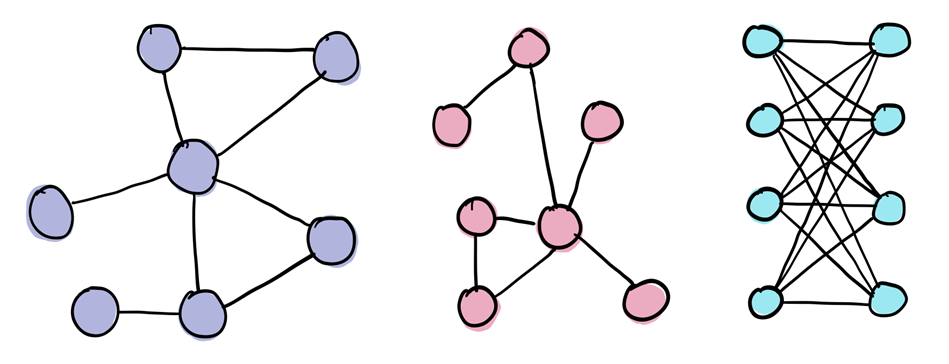

Graphs are composed of a collection of interconnected nodes. For example, here is a six-node graph:

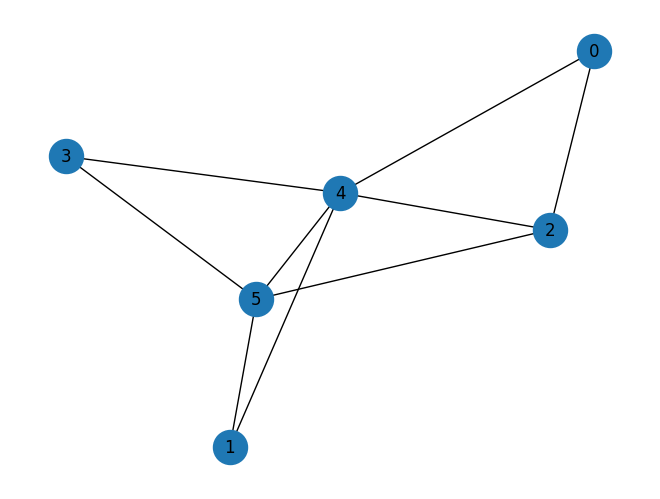

In [1]:
import networkx as nx

n_nodes = 6
p = 0.5  # probability of an edge
seed = 1968

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions, node_size=600)

Many practical use-cases can be mapped to a graph structure. In a social network, the nodes of a graph can represent users and the edges can represent connections between the users.

We often need to solve optimization problems to identify important properties of the graph. These problems can include:

- finding large clusters of fully connected nodes (known as [maximum clique](https://en.wikipedia.org/wiki/Clique_problem))
- finding a minimum number of nodes that connect to every edge in the graph (known as [minimum vertex cover](https://en.wikipedia.org/wiki/Vertex_cover))
- finding a partition of the nodes into two subsets so that the greatest number of edges are intersected (known as [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut))

This tutorial shows how a quantum algorithm called QAOA can be run using PennyLane and Braket to solve graph-based optimization problems. We begin with a small 6-node graph and then push the limits to run a 20-node graph using parallel executions on SV1.

<div class="alert alert-block alert-info">
<b>Note</b> This notebook requires PennyLane version 0.17 or above.
</div>

## QAOA

The quantum approximate optimization algorithm (QAOA) is an algorithm designed for near-term hardware. It can find approximate solutions to combinatorial optimization problems such as graph-based problems.

QAOA begins by associating the optimization problem with a cost Hamiltonian $H_C$ and choosing a mixer Hamiltonian $H_{M}$. It proceeds by repetitively applying multiple layers of the unitaries $\exp{(-i \gamma_i H_C)}$ and $\exp{(-i \alpha_i H_M)}$ with controllable parameters $\gamma_i$ and $\alpha_i$, as shown in the diagram below.

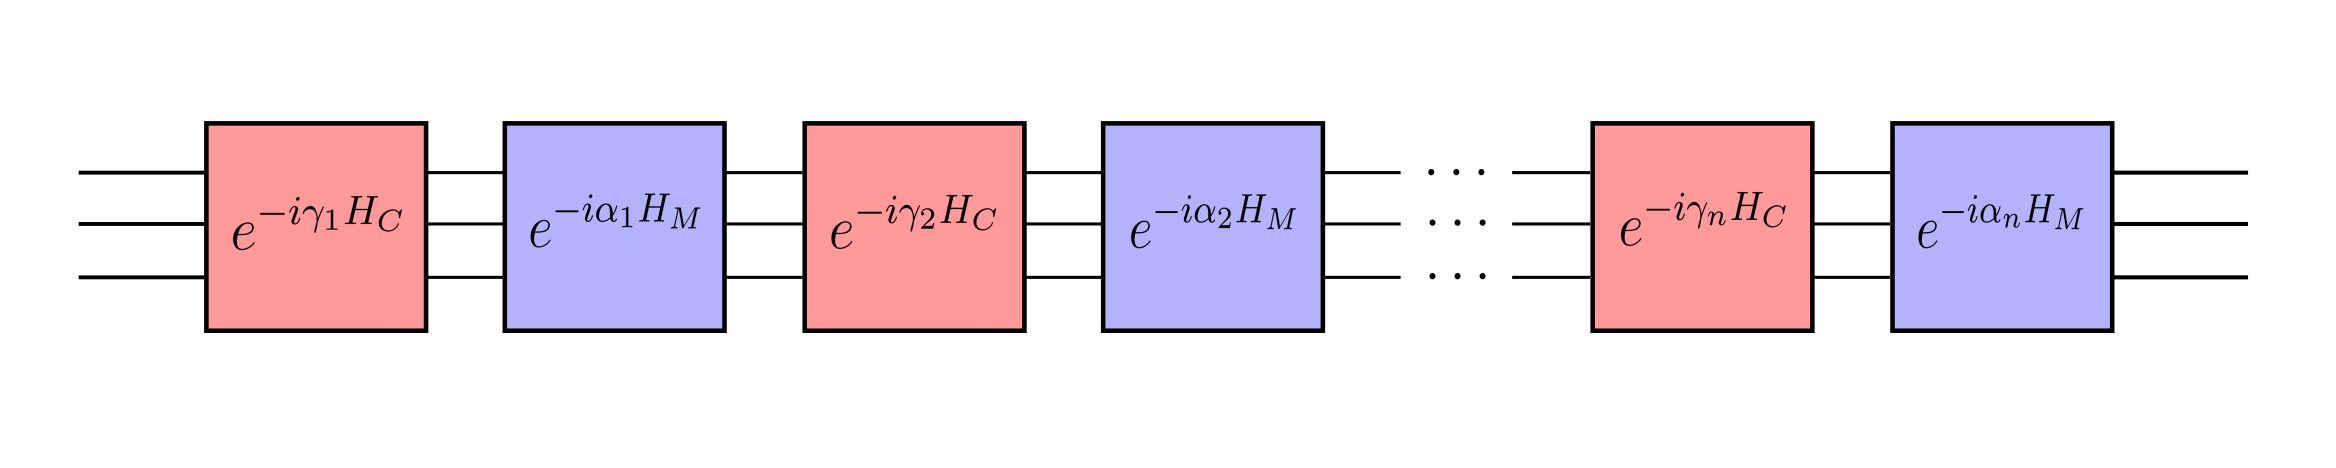

The algorithm then measures the cost Hamiltonian $H_C$. By varying the controllable parameters $\gamma_i$ and $\alpha_i$, the expectation value of the cost Hamiltonian is minimized. Applying the optimized unitaries prepares a quantum state that contains information about the optimal configuration for the problem. Sampling from the state will give a candidate solution.

In summary the algorithm involves an optimization of the controllable parameters $\gamma_i$ and $\alpha_i$ that the quantum circuit depends on.

## Fixing the problem

Let's consider the graph above and aim to find the minimun vertex cover, i.e., the smaller set of nodes that includes at least one endpoint of every edge of the graph. 

To solve this using QAOA in PennyLane and Braket, we first calculate the cost Hamiltonian $H_C$ and corresponding mixer Hamiltonian $H_M$

In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa as mvc

cost_h, mixer_h = qml.qaoa.min_vertex_cover(g, constrained=False)
# constrained=True results in greater circuit depth but potentially better solutions

print("Cost Hamiltonian:\n", cost_h)
print("Mixer Hamiltonian:\n", mixer_h)

Cost Hamiltonian:
   (0.5) [Z9]
+ (1.25) [Z15]
+ (1.25) [Z13]
+ (1.25) [Z14]
+ (2.0) [Z1]
+ (2.0) [Z6]
+ (2.0) [Z16]
+ (2.75) [Z0]
+ (2.75) [Z11]
+ (2.75) [Z4]
+ (2.75) [Z2]
+ (2.75) [Z3]
+ (2.75) [Z8]
+ (3.5) [Z7]
+ (4.25) [Z10]
+ (4.25) [Z5]
+ (4.25) [Z12]
+ (0.75) [Z0 Z10]
+ (0.75) [Z0 Z11]
+ (0.75) [Z0 Z4]
+ (0.75) [Z0 Z15]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z10]
+ (0.75) [Z1 Z7]
+ (0.75) [Z1 Z6]
+ (0.75) [Z1 Z5]
+ (0.75) [Z2 Z12]
+ (0.75) [Z2 Z10]
+ (0.75) [Z2 Z4]
+ (0.75) [Z2 Z13]
+ (0.75) [Z3 Z7]
+ (0.75) [Z3 Z12]
+ (0.75) [Z3 Z14]
+ (0.75) [Z3 Z8]
+ (0.75) [Z3 Z5]
+ (0.75) [Z4 Z11]
+ (0.75) [Z4 Z9]
+ (0.75) [Z4 Z10]
+ (0.75) [Z5 Z16]
+ (0.75) [Z5 Z6]
+ (0.75) [Z5 Z12]
+ (0.75) [Z5 Z8]
+ (0.75) [Z5 Z9]
+ (0.75) [Z6 Z12]
+ (0.75) [Z6 Z10]
+ (0.75) [Z7 Z16]
+ (0.75) [Z7 Z10]
+ (0.75) [Z7 Z14]
+ (0.75) [Z7 Z12]
+ (0.75) [Z8 Z14]
+ (0.75) [Z8 Z12]
+ (0.75) [Z8 Z11]
+ (0.75) [Z10 Z11]
+ (0.75) [Z11 Z13]
+ (0.75) [Z12 Z15]
+ (0.75) [Z13 Z16]
+ (0.75) [Z15 Z16]
Mixer Hamiltonian:
   (1) [X0

## Setting up the algorithm

We begin by setting up a single QAOA layer

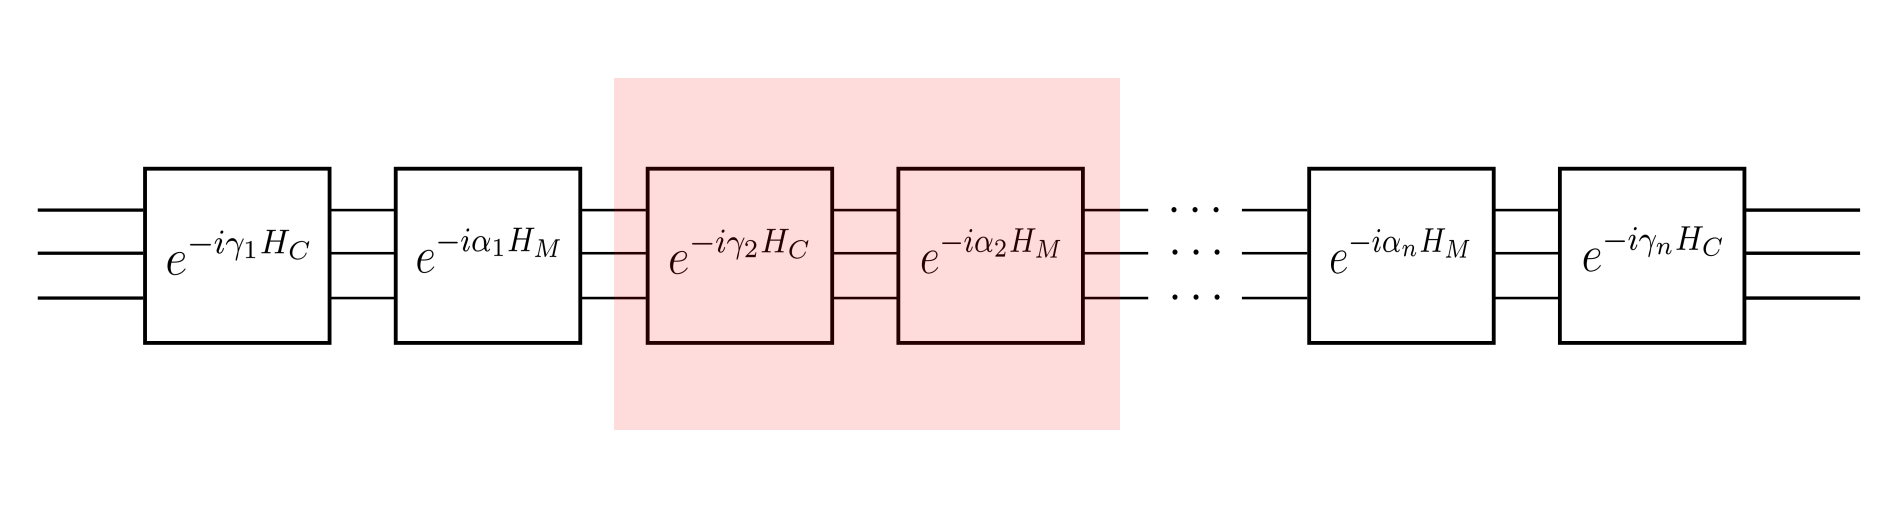

This layer contains the controllable parameters $\gamma_i$ and $\alpha_i$.

In [17]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

The full QAOA circuit is then given by:

In [18]:
n_layers = 4
wires = n_nodes

def circuit(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

<div class="alert alert-block alert-info">
<b>Note</b> We have chosen to use 4 QAOA layers. The choice of depth is a tradeoff between improved solutions (for greater depth) and increasing runtime.
</div>

There are overall eight controllable parameters: the first four are for $\gamma_i$ of the cost Hamiltonian and the second four are for $\alpha_i$ of the mixer Hamiltonian:

In [19]:
np.random.seed(1967)
params = np.random.uniform(size=[2, n_layers])
params

tensor([[0.72511958, 0.57312068, 0.6448612 , 0.55801009],
        [0.94368854, 0.93863944, 0.52819152, 0.5817428 ]], requires_grad=True)

For this part of the tutorial, we will use the local Braket simulator (see the [introduction tutorial](./0_Getting_started.ipynb) for further details):

In [20]:
dev = qml.device("braket.local.qubit", wires=wires)

The final step is to define the cost function. In QAOA, the output cost function is given by the expectation value of the cost Hamiltonian $H_C$, i.e.,

In [21]:
@qml.qnode(dev)
def cost_function(params, **kwargs):
    circuit(params)
    return qml.expval(cost_h)

## Running the algorithm

Now that we have set up the cost function, we just need to pick an optimizer and run the standard optimization loop.

In [22]:
optimizer = qml.GradientDescentOptimizer()

In [9]:
print("Initial cost:", cost_function(params))

for i in range(10):
    params = optimizer.step(cost_function, params)
    cost_eval = cost_function(params)
    print(f"Completed iteration {i + 1}, cost function:", cost_eval)

Initial cost: -0.48003149748182505
Completed iteration 1, cost function: -0.6989021726738048
Completed iteration 2, cost function: -0.8061071325934226
Completed iteration 3, cost function: -0.9120522098217234
Completed iteration 4, cost function: -1.0284753199202425
Completed iteration 5, cost function: -1.1623201187497476
Completed iteration 6, cost function: -1.3215834920320653
Completed iteration 7, cost function: -1.5163064556085122
Completed iteration 8, cost function: -1.7450877868779053
Completed iteration 9, cost function: -1.9686267013633445
Completed iteration 10, cost function: -2.1378201173681455


In [16]:
params

tensor([[0.50665484, 0.63403892, 0.5175575 , 0.67814753],
        [0.82722158, 1.09564936, 0.45021019, 0.47649189]], requires_grad=True)

## Investigating the result

How do we know how well the algorithm has performed? To do this, we can sample from the circuit using the optimized parameters. This will give us binary samples that allow us to select which nodes of the graph to use as part of our clique, e.g., either by simply selecting the most common sample or selecting the sample with the lowest corresponding energy.

Let's take some samples and see which ones occur most frequently. To start, we'll create a QNode designed for sampling.

In [17]:
shots = 100000
dev = qml.device("braket.local.qubit", wires=wires, shots=shots)

@qml.qnode(dev)
def samples(params):
    circuit(params)
    return [qml.sample(qml.PauliZ(i)) for i in range(wires)]

Samples can now be generated and converted into probabilities:

In [18]:
from collections import Counter

s = samples(params).T
s = (1 - s.numpy()) / 2
s = map(tuple, s)

counts = Counter(s)
indx = np.ndindex(*[2] * wires)

probs = {p: counts.get(p, 0) / shots for p in indx}

We can now plot the probability distribution over all possible samples:

/tmp/ipykernel_3507/209843119.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


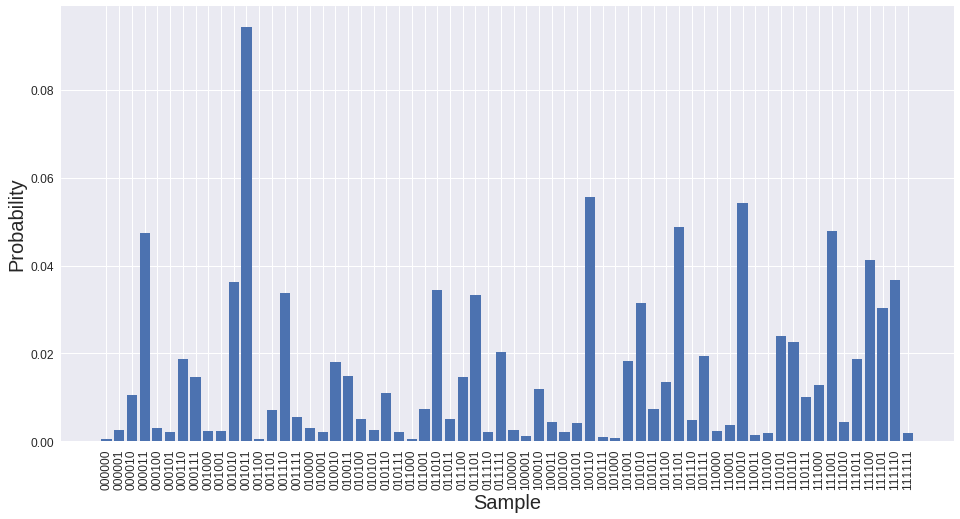

In [19]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]

plt.bar(range(2 ** wires), probs.values())
plt.xticks([i for i in range(len(probs))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

The sample with higher probabiliy is:

In [20]:
max_prob=0
most_prob_result = ""

for item in probs.items():
    if item[1] > max_prob:
        max_prob = item[1]
        most_prob_result = item[0]
        
most_prob_result

(0, 0, 1, 0, 1, 1)

Since each qubit corresponds to a node, this sample selects the nodes codified as '1' to form a subgraph. Let's check if this is a clique, i.e., if all of the nodes are connected:

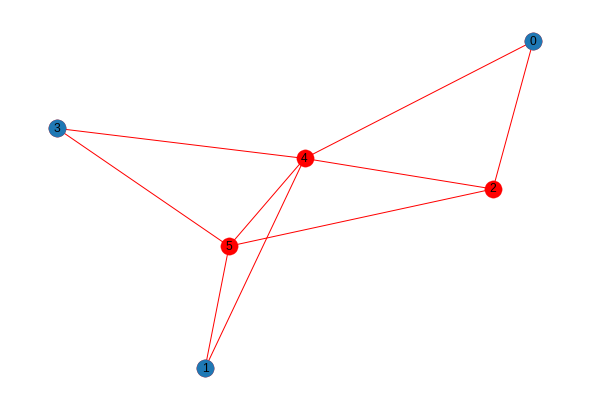

In [21]:
subgraph=[]
for i in range(n_nodes):
    if most_prob_result[i] == 0:
        subgraph.append(i)
    

sub = g.subgraph(subgraph)
nx.draw(g, pos=positions, with_labels=True, node_color="r", edge_color="r")
nx.draw(sub, pos=positions)

Great, this is a vertex cover! Moreover, it is the *largest* clique in this six-node graph. QAOA, using PennyLane and Braket, has helped us to solve the minimun vertex cover problem!

## Scaling-up QAOA for larger graphs

We have seen how we can use PennyLane on Braket to solve graph optimization problems with QAOA. However, we have so far restricted to a simple six-node graph and used the local Braket device. Let's now be more ambitious and try to solve an optimization problem on a twenty-node graph!

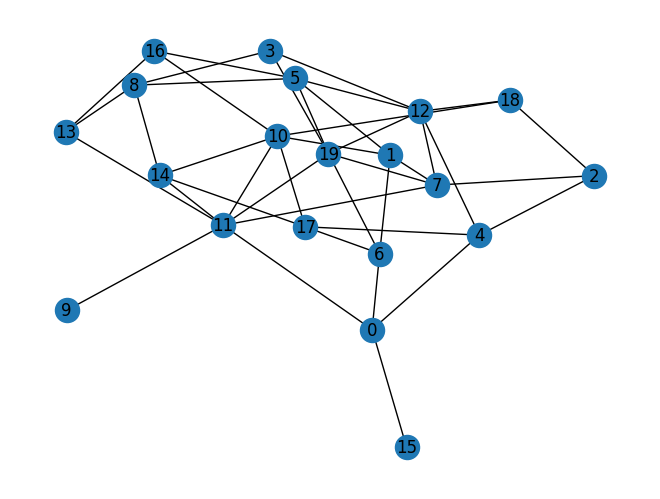

In [23]:
import networkx as nx

nodes = wires = int(20)
edges = int(40)
seed = 1967

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions)

A twenty-node graph (which maps to the same number of qubits) definitely puts us in a regime where the local simulator will be slow to execute. As we have discussed in the [parallelization tutorial](./1_Parallelized_optimization_of_quantum_circuits.ipynb), this slowness will be compounded when it comes to training the circuit, with each optimization step resulting in multiple device executions due to calculation of the gradient. Thankfully, the remote SV1 simulator is highly suited to speeding up gradient calculations through paralellization. We now show that this makes training the circuit for QAOA solvable within a reasonable time.

Let's first load a new device:

In [24]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/dm1"

In [25]:
dev = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    parallel=True,
    max_parallel=20,
    poll_timeout_seconds=30,
)

ClientError: An error occurred (500) when calling the GetDevice operation (reached max retries: 4): 

Note the specification of ``max_parallel=20``. This means that up to ``20`` circuits will be executed in parallel on SV1 (the default value is ``10``).

<div class="alert alert-block alert-warning">
<b>Caution:</b> Increasing the maximum number of parallel executions can result in a greater rate of spending on simulation fees. The value must also be set bearing in mind your
    service <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-quotas.html">quota</a>, which can be found <a href="https://console.aws.amazon.com/servicequotas/home">here</a>. Similarly, if you instead choose to run the QAOA problem on a QPU, it can take a long time and incur high <a href="https://aws.amazon.com/braket/pricing/">usage fees</a>. 
</div>

We now just need to set up the QAOA circuit and optimization problem in the same way as before. However, we will switch to a new optimization problem to keep things interesting: aiming to solve minimun vertex cover, with the objective of partitioning the graph's nodes into a minimal set of vertices that includes at least one endpoint of every edge of the graph. This problem is NP-hard, so we expect it to be tough as we increase the number of graph nodes.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Minimum-vertex-cover.svg/1280px-Minimum-vertex-cover.svg.png" alt="Minimun vertex cover" />

In [22]:
cost_h, mixer_h = qml.qaoa.min_vertex_cover(g)

In [23]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

In [24]:
n_layers = 2

@qml.qnode(dev)
def cost_function(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])
    return qml.expval(cost_h)

In [25]:
np.random.seed(1967)
params = 0.01 * np.random.uniform(size=[2, n_layers])

A variety of [optimizers](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html) are available in PennyLane. Let's choose ``AdagradOptimizer``:

In [26]:
optimizer = qml.AdagradOptimizer(stepsize=0.1)

We're now set up to train the circuit! Note, if you are training this circuit yourself, you may want to increase the number of iterations in the optimization loop and also investigate changing the number of QAOA layers.

<div class="alert alert-block alert-warning">
<b>Caution:</b> Running the following cell will take a long time and will result in <a href="https://aws.amazon.com/braket/pricing/">usage fees</a> charged to your AWS account. Only uncomment the cell if you are comfortable with the potential wait-time and costs. We recommend monitoring the Billing & Cost Management Dashboard on the AWS console and being aware that jobs involving a large number of qubits can be costly.
</div>

In [27]:
import time

iterations = 10

for i in range(iterations):    
     t0 = time.time()
    
     params, cost_before = optimizer.step_and_cost(cost_function, params)    

     t1 = time.time()
    
     if i == 0:
         print("Initial cost:", cost_before)
     else:
         print(f"Cost at step {i}:", cost_before)

     print(f"Completed iteration {i + 1}")
     print(f"Time to complete iteration: {t1 - t0} seconds")

print(f"Cost at step {iterations}:", cost_function(params))

np.save("params.npy", params)
print("Parameters saved to params.npy")

<code>
Initial cost: -29.98570234095951
Completed iteration 1
Time to complete iteration: 93.96246099472046 seconds
Cost at step 1: -27.154071768632154
Completed iteration 2
Time to complete iteration: 84.80994844436646 seconds
Cost at step 2: -29.98726230006233
Completed iteration 3
Time to complete iteration: 83.13504934310913 seconds
Cost at step 3: -29.999163153600062
Completed iteration 4
Time to complete iteration: 85.61391234397888 seconds
Cost at step 4: -30.002158646044307
Completed iteration 5
Time to complete iteration: 86.70688223838806 seconds
Cost at step 5: -30.012058444011906
Completed iteration 6
Time to complete iteration: 83.26341080665588 seconds
Cost at step 6: -30.063709712612443
Completed iteration 7
Time to complete iteration: 85.25566911697388 seconds
Cost at step 7: -30.32522304705352
Completed iteration 8
Time to complete iteration: 83.55433392524719 seconds
Cost at step 8: -31.411030331978186
Completed iteration 9
Time to complete iteration: 84.08745908737183 seconds
Cost at step 9: -33.87153965616938
Completed iteration 10
Time to complete iteration: 87.4032838344574 seconds
Cost at step 10: -36.05424874438809
Parameters saved to params.npy
</code>

This example shows us that a 20-qubit QAOA problem can be trained within around 1-2 minutes per iteration by using parallel executions on the Amazon Braket SV1 device to speed up gradient calculations. If this problem were run on the local Braket simulator without parallelization, we would expect for training to take much longer.

Pre-optimized parameters for the above 2-layer QAOA circuit after 30 iterations can be loaded with:

In [23]:
params_30 = np.load("params_30.npy")

<div class="alert alert-block alert-info">
<b>What's next?</b> See if you can analyze the trained QAOA circuit for the 20-node graph by adapting the earlier analysis. Also, check out the followup tutorial on quantum chemistry.
</div>